# Demo of `SphereAdaSTEM` model: a spherical indexing and modeling system

Yangkang Chen<br>
Jan 24, 2024

This notebook is to show the main difference of `SphereAdaSTEM` compared to `AdaSTEM`. To be specific, only the gridding part is different, and all other functionalities are inherited from `AdaSTEM` class. For complete functionality, please refer to [AdaSTEM Demo](https://chenyangkang.github.io/stemflow/Examples/01.AdaSTEM_demo.html).

We will explore the same modeling task as [AdaSTEM Demo](https://chenyangkang.github.io/stemflow/Examples/01.AdaSTEM_demo.html) did: Predict the abundance of [Mallard](https://en.wikipedia.org/wiki/Mallard) (a bird species) based on environmental variables. The data were requested from [eBird](https://ebird.org/home), a citizen science project for bird observation, and with some variable annotation.

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle
import os
import h3pandas

pd.set_option('display.max_columns', None)
# warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

## Download data

### Training/test data

Please download the sample data from:<br>
- Mallard: https://figshare.com/articles/dataset/Sample_data_Mallard_csv/24080745<br>

Suppose now it's downloaded and saved as './Sample_data_Mallard.csv'<br>

Alternatively, you can try other species like <br>
- Alder Flycatcher: https://figshare.com/articles/dataset/Sample_data_Alder_Flycatcher_csv/24080751<br>
- Short-eared Owl: https://figshare.com/articles/dataset/Sample_data_Short-eared_Owl_csv/24080742<br>
- Eurasian Tree Sparrow: https://figshare.com/articles/dataset/Sample_data_Eurasian_Tree_Sparrow_csv/24080748<br>

**Caveat: These bird observation data are about 200MB each file.**

In [3]:
data = pd.read_csv(f'./Sample_data_Mallard.csv')
data = data.drop('sampling_event_identifier', axis=1)


### Prediction set

Prediction set are used to feed into a trained AdaSTEM model and make prediction: at some location, at some day of year, given the environmental variables, how many Mallard individual do I expected to observe?

The prediction set will be loaded after the model is trained.

Download the prediction set from: https://figshare.com/articles/dataset/Predset_2020_csv/24124980

**Caveat: The file is about 700MB.**

## Get X and y

In [4]:
X = data.drop('count', axis=1)
y = data['count'].values


In [5]:
X.head()

,longitude,latitude,DOY,duration_minutes,Traveling,Stationary,Area,effort_distance_km,number_observers,obsvr_species_count,time_observation_started_minute_of_day,elevation_mean,slope_mean,eastness_mean,northness_mean,bio1,bio2,bio3,bio4,bio5,bio6,bio7,bio8,bio9,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19,closed_shrublands,cropland_or_natural_vegetation_mosaics,croplands,deciduous_broadleaf_forests,deciduous_needleleaf_forests,evergreen_broadleaf_forests,evergreen_needleleaf_forests,grasslands,mixed_forests,non_vegetated_lands,open_shrublands,permanent_wetlands,savannas,urban_and_built_up_lands,water_bodies,woody_savannas,entropy
0,-83.472224,8.859308,22,300.0,1,0,0,4.828,5.0,34.0,476,7.555556,0.758156,0.036083,-0.021484,24.883502,5.174890,59.628088,93.482247,30.529131,21.850519,8.678612,24.302626,26.536822,26.213334,23.864924,0.720487,0.127594,0.003156,0.001451,0.332425,0.026401,0.044218,0.260672,0.0,0.000000,0.0,0.0,0.0,0.138889,0.000000,0.000000,0.000000,0.0,0.0,0.777778,0.000000,0.000000,0.083333,0.000000,0.676720
1,-2.687724,43.373323,290,90.0,1,0,0,0.570,2.0,151.0,1075,30.833336,3.376527,0.050544,-0.099299,14.107917,5.224109,31.174167,376.543853,23.219421,6.461607,16.757814,9.048385,19.092725,19.236082,9.287841,0.171423,0.035598,0.004512,0.000081,0.084657,0.018400,0.030210,0.065007,0.0,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.083333,0.0,0.0,0.000000,0.194444,0.027778,0.000000,0.361111,1.359063
2,-89.884770,35.087255,141,10.0,0,1,0,-1.000,2.0,678.0,575,91.777780,0.558100,-0.187924,-0.269078,17.396487,8.673912,28.688889,718.996078,32.948335,2.713938,30.234397,14.741099,13.759220,26.795849,7.747272,0.187089,0.031802,0.005878,0.000044,0.073328,0.026618,0.039616,0.059673,0.0,0.055556,0.0,0.0,0.0,0.000000,0.000000,0.305556,0.000000,0.0,0.0,0.000000,0.527778,0.000000,0.000000,0.111111,1.104278
3,-99.216873,31.218510,104,9.0,1,0,0,0.805,2.0,976.0,657,553.166700,0.856235,-0.347514,-0.342971,20.740836,10.665164,35.409121,666.796919,35.909941,5.790119,30.119822,18.444353,30.734456,29.546417,11.701038,0.084375,0.025289,0.000791,0.000052,0.052866,0.004096,0.006064,0.015965,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
4,-124.426730,43.065847,96,30.0,1,0,0,0.161,2.0,654.0,600,6.500000,0.491816,-0.347794,-0.007017,11.822340,6.766870,35.672897,396.157833,22.608788,3.639569,18.969219,8.184412,16.290802,17.258721,7.319234,0.144122,0.044062,0.000211,0.000147,0.089238,0.004435,0.004822,0.040621,0.0,0.000000,0.0,0.0,0.0,0.361111,0.166667,0.000000,0.472222,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.020754


The features include:

- spatial coordinates:
  - `longitude` and `latitude` (used for indexing, not actual training)
    
- Temporal coordinate:
  - day of year (`DOY`): used for both indexing and training

- Sampling parameters: These are parameters quantifying how the observation was made
  - `duration_minutes`: How long the observation was conducted
  - Observation protocol: `Traveling`, `Stationary`, or `Area`
  -  `effort_distance_km`: how far have one traveled
  -  `number_observers`: How many observers are there in the group
  - `obsvr_species_count`: How many bird species have the birder observed in the past
  - `time_observation_started_minute_of_day`: When did the birder start birding

- Topological features:
  - Features of elevation: `elevation_mean`
  - Features of slope magnitude and direction: `slope_mean`, `eastness_mean`, `northness_mean`

- Bioclimate features:
  - Summaries of yearly temperature and precipitation: from `bio1` to `bio19`

- Land cover features:
  - Summaries of land cover, percentage of cover. For example, `closed_shrublands`,  `urban_and_built_up_lands`.
  - `entropy`: Entropy of land cover


As you can see, the environmental variables are almost static. However, dynamic features (e.g., daily temperature) is fully supported as input. See [Tips for data types](https://chenyangkang.github.io/stemflow/Tips/Tips_for_data_types.html) for details.
  
  
 

Now we can take a look at the target variable

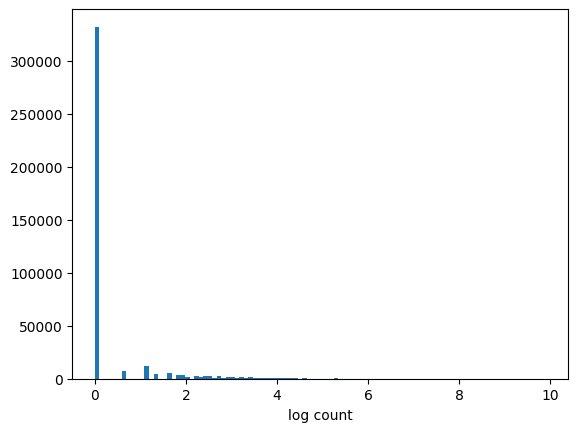

Percentage record with zero Mallard count: 83.09425%


In [6]:
plt.hist(np.log(y+1),bins=100)
plt.xlabel('log count')
plt.show()

zero_frac = np.sum(y==0)/len(y)
print(f'Percentage record with zero Mallard count: {zero_frac*100}%')


The target data is extremely zero-inflated. 83% checklists have not Mallard observation. This poses the necessity of using [hurdle model](https://chenyangkang.github.io/stemflow/Tips/Tips_for_different_tasks.html).

## First thing first: Spatiotemporal train test split

In [7]:
from stemflow.model_selection import ST_train_test_split
X_train, X_test, y_train, y_test = ST_train_test_split(X, y, 
                                                        Spatio1 = 'longitude',
                                                        Spatio2 = 'latitude',
                                                        Temporal1 = 'DOY',
                                                        Spatio_blocks_count = 50, Temporal_blocks_count=50,
                                                        random_state=42, test_size=0.3)


This makes sure that we have a held-out test set, so that the estimation will be reliable.

For details of parameter setting, see [AdaSTEM Demo](https://chenyangkang.github.io/stemflow/Examples/01.AdaSTEM_demo.html).


## Train AdaSTEM hurdle model

In [8]:
from stemflow.model.SphereAdaSTEM import SphereAdaSTEM, SphereAdaSTEMClassifier, SphereAdaSTEMRegressor
from xgboost import XGBClassifier, XGBRegressor # remember to install xgboost if you use it as base model
from stemflow.model.Hurdle import Hurdle_for_AdaSTEM, Hurdle


We first import the models. Although some classes are not used, I imported them for complete showcase of function.

Here, we import the `SphereAdaSTEM`, `SphereAdaSTEMClassifier` and `SphereAdaSTEMRegressor` from `stemflow.model.SphereAdaSTEM` module.

In [9]:
## "hurdle in Ada"
model = SphereAdaSTEMRegressor(
    base_model=Hurdle(
        classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
        regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1)
    ),                                      # hurdel model for zero-inflated problem (e.g., count)
    save_gridding_plot = True,
    ensemble_fold=10,                       # data are modeled 10 times, each time with jitter and rotation in Quadtree algo
    min_ensemble_required=7,                # Only points covered by > 7 stixels will be predicted
    grid_len_upper_threshold=2500,            # force splitting if the grid length exceeds 2500 (km)
    grid_len_lower_threshold=500,             # stop splitting if the grid length fall short 500 (km)        
    temporal_start=1,                       # The next 4 params define the temporal sliding window
    temporal_end=366,                            
    temporal_step=25,                       # The window takes steps of 20 DOY (see AdaSTEM demo for details)
    temporal_bin_interval=50,               # Each window will contain data of 50 DOY
    points_lower_threshold=50,              # Only stixels with more than 50 samples are trained
    Temporal1='DOY',
    use_temporal_to_train=True,             # In each stixel, whether 'DOY' should be a predictor
    njobs=1
)

The parameter setting is mostly similar to [AdaSTEM](https://chenyangkang.github.io/stemflow/Examples/01.AdaSTEM_demo.html). The differences is that:

1. We use `SphereAdaSTEMRegressor` as regressor, and
1. We set `grid_len_upper_threshold` and `grid_len_lower_threshold` as real distance in kilometers, although the spatial columns are `longitude` and `latitude`.
1. **You must have a column named "longitude" and a column named "latitude" in you dataframe**. The grid will be generated on the fly, and gridding will be based on real distance.


For other details of parameter setting, see [AdaSTEM Demo](https://chenyangkang.github.io/stemflow/Examples/01.AdaSTEM_demo.html).


We then fit the model by simply call:

In [10]:
# columns of X_train should only contain predictors and Spatio-temporal indicators ('longitude', 'latitude', Temporal1)
model.fit(X_train.reset_index(drop=True), y_train, verbosity=1)


Generating Ensemble: 100%|██████████| 10/10 [07:21<00:00, 44.14s/it]


training:   0%|          | 0/10 [00:00<?, ?it/s]

SphereAdaSTEMRegressor(base_model=Hurdle(classifier=XGBClassifier(base_score=None,
                                                                  booster=None,
                                                                  callbacks=None,
                                                                  colsample_bylevel=None,
                                                                  colsample_bynode=None,
                                                                  colsample_bytree=None,
                                                                  early_stopping_rounds=None,
                                                                  enable_categorical=False,
                                                                  eval_metric=None,
                                                                  feature_types=None,
                                                                  gamma=None,
                                                                  gpu_id=None,
                                                                  grow_policy=None,
                                                                  importance_type=None,
                                                                  interaction_constraints=...
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=None,
                                                                max_leaves=None,
                                                                min_child_weight=None,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                n_estimators=100,
                                                                n_jobs=1,
                                                                num_parallel_tree=None,
                                                                predictor=None,
                                                                random_state=42, ...)),
                       grid_len_upper_threshold=2500, save_gridding_plot=True,
                       stixel_training_size_threshold=50, temporal_step=25)

## Plot QuadTree ensembles

In [11]:
model.gridding_plot

![Sphere Gridding](https://chenyangkang.github.io/stemflow/assets/Sphere_gridding.png)

Here for an interactive plot [Interactive spherical gridding plot](https://chenyangkang.github.io/stemflow/assets/Sphere_gridding.html).

In [12]:

with open('sphere_gridding_plot.html','w') as f:
    f.write(model.gridding_plot.to_html())
    

This shows the 10 Quadtree ensembles we made. Region with higher data volume were split into smaller gird. The grid length is constrained between `(500, 2500)` kilometers.

## Feature importances

After training the model, now we are interested in what features are important in bird abundance prediction

In [13]:
# Calcualte feature importance.
model.calculate_feature_importances()
# stixel-specific feature importance is saved in model.feature_importances_

In [14]:
top10_features = model.feature_importances_.iloc[:,1:].rank(axis=1).mean(axis=0).sort_values(ascending=False).head(10)
top10_features

slope_mean             34.278389
effort_distance_km     33.836596
elevation_mean         32.857154
northness_mean         30.856551
bio4                   30.786596
eastness_mean          30.688630
duration_minutes       30.666340
obsvr_species_count    30.222590
bio8                   29.530572
bio2                   29.444051
dtype: float64

`slope_mean`, `effort_distance_km`, and `elevation_mean` are the top 3 predictors of Mallard abundance across the sampled space and time. 

The feature importance ranking is similar to the results of [`AdaSTEM`](https://chenyangkang.github.io/stemflow/Examples/01.AdaSTEM_demo.html).


## Evaluation

Now, we evaluate our overall model performance on the held-out test set:

In [15]:
pred = model.predict(X_test, verbosity=1)

predicting:   0%|          | 0/10 [00:00<?, ?it/s]

The samples not predictable are output as `np.nan`:

In [16]:
perc = np.sum(np.isnan(pred.flatten()))/len(pred.flatten())
print(f'Percentage not predictable {round(perc*100, 2)}%')

Percentage not predictable 0.02%


More points are predictable compared to `AdaSTEM` model (0.02% unpredictable compared to ~1% unpredictable)! This is expected, as the Sphere indexing system enclose almost every corner of the earth.

We evaluate the performance using various metrics implemented in `SphereAdaSTEM.eval_STEM_res` or `AdaSTEM.eval_STEM_res` method:

In [17]:
pred_df = pd.DataFrame({
    'y_true':y_test.flatten(),
    'y_pred':np.where(pred.flatten()<0, 0, pred.flatten())
}).dropna()

SphereAdaSTEM.eval_STEM_res('hurdle', pred_df.y_true, pred_df.y_pred)

{'AUC': 0.7709769441127502,
 'kappa': 0.40418935376349774,
 'f1': 0.5315554903435247,
 'precision': 0.4095122364777031,
 'recall': 0.7572242253226733,
 'average_precision': 0.35007503024002873,
 'Spearman_r': 0.47773497480632715,
 'Pearson_r': 0.20838678841242564,
 'R2': -0.010718003793811492,
 'MAE': 4.0526054794665,
 'MSE': 1270.2122920088268,
 'poisson_deviance_explained': 0.14793642063493806}

The model performance is similar compared to `AdaSTEM` model. The model performance should mainly be a result of parameters like `ensemble_fold` and `points_lower_threshold`, rather than the 2D or 3D gridding system.




## Save model

We use `pickle` to save the model:

In [18]:
with open('./01.demo_adastem_model.pkl','wb') as f:
    pickle.dump(model, f)

To load the model, do:

In [19]:
with open('./01.demo_adastem_model.pkl','rb') as f:
    model = pickle.load(f)


## Calculate memory usage

Finally, we are interested in how many disk space & memory our model consumed. `stemflow` is typically memory costly, especially when data volume and ensembles go up – the memory usage may also go up linearly. We do not currently provide solution for memory optimization. We well come PR to work on that.

In [20]:
# Calculate memory usage
model_size_G = round(os.path.getsize('./01.demo_adastem_model.pkl')/1024/1024/1024, 2)
training_data_memory_G = round(X.memory_usage().sum()/1024/1024/1024, 2)

# Calculate model info
true_hurdle_model_count = np.sum([1 if isinstance(model.model_dict[i].classifier, XGBClassifier) else 0 for i in model.model_dict])
dummy_model_count = len(model.model_dict) - true_hurdle_model_count
true_hurdle_model_perc = round(true_hurdle_model_count/len(model.model_dict) * 100, 2)
dummy_model_perc = round(dummy_model_count/len(model.model_dict) * 100, 2)


In [21]:
print(f"""
      
      This AdaSTEM model have {len(model.model_dict)} trained based models in total.
      Among them, {dummy_model_count} ({dummy_model_perc}%) are dummy models that always predict one class (because the input data labels are homogeneous).
      Oppositely, {true_hurdle_model_count} ({true_hurdle_model_perc}%) are true hurdle models.
      
      The input data consume {training_data_memory_G} G memory.
      The model takes {model_size_G} G space on the disks.
      
""")



      
      This AdaSTEM model have 6640 trained based models in total.
      Among them, 1229 (18.51%) are dummy models that always predict one class (because the input data labels are homogeneous).
      Oppositely, 5411 (81.49%) are true hurdle models.
      
      The input data consume 0.15 G memory.
      The model takes 1.7 G space on the disks.
      



## Conclusion

Although we cannot directly compare the speed and performance of two modeling framework with different parameter settings, the results definitely show that, with similar gridding parameters:

For training:
1. `AdaSTEM` and `SphereAdaSTEM` have similar speed.
1. `SphereAdaSTEM` spends longer on gridding, but not significantly.

For prediction:
1. `SphereAdaSTEM` has higher coverage, and therefore more samples in the test set can be predicted.
1. The prediction speed of `SphereAdaSTEM` is almost double slower than `AdaSTEM`.
2. The model performance is similar in terms of all metrics.

For memory use:
1. The two model consume similar amount of memory.


My suggestion is that:
1. For local modeling, you could use `AdaSTEM` for simplicity and understandability.
1. For global modeling, if you don't mind the difference in speed, you can use `SphereAdaSTEM`.
1. For samples that distributed much towards the poles, definitely use `SphereAdaSTEM`.



**Please open an issue if you have any question**

**Cheers!**


In [22]:
from watermark import watermark
print(watermark())
print(watermark(packages="stemflow,numpy,scipy,pandas,xgboost,tqdm,matplotlib,h3pandas,geopandas,scikit-learn"))


Last updated: 2024-01-24T21:47:37.851624+08:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.14.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

stemflow    : 1.0.9.4
numpy       : 1.24.3
scipy       : 1.10.1
pandas      : 2.0.3
xgboost     : 1.7.6
tqdm        : 4.65.0
matplotlib  : 3.7.1
h3pandas    : 0.2.4
geopandas   : 0.11.1
scikit-learn: 0.0

